In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/PP-1/Implementation/Datasets/UMAFall.zip

Archive:  /content/drive/MyDrive/PP-1/Implementation/Datasets/UMAFall.zip
   creating: UMAFall/
   creating: UMAFall/ADL/
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_Aplausing_1_2017-04-14_23-38-23.txt  
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_Aplausing_2_2017-04-14_23-38-59.txt  
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_Aplausing_3_2017-04-14_23-39-35.txt  
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_HandsUp_1_2017-04-14_23-32-44.txt  
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_HandsUp_2_2017-04-14_23-33-21.txt  
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_HandsUp_3_2017-04-14_23-33-59.txt  
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_MakingACall_1_2017-04-14_23-30-27.txt  
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_MakingACall_2_2017-04-14_23-31-05.txt  
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_MakingACall_3_2017-04-14_23-31-42.txt  
  inflating: UMAFall/ADL/UMAFall_Subject_01_ADL_OpeningDoor_1_2017-04-14_23-35-12.txt  
  inflating: UMA

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
# Function to load and preprocess data
def load_and_preprocess_data(folder_path, label):
    data = []
    labels = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as file:
                # Read the first 10 seconds of data
                raw_data = np.loadtxt(file, usecols=(0, 1, 2), max_rows=200)
                # Normalize the data
                normalized_data = raw_data / 16.0  # Assuming the maximum range is 16 G
                data.append(normalized_data)
                labels.append(label)

    return np.array(data), np.array(labels)

# Load and preprocess data for ADL and FALL
adl_data, adl_labels = load_and_preprocess_data('/content/UMAFall/ADL', label=0)
fall_data, fall_labels = load_and_preprocess_data('/content/UMAFall/FALL', label=1)

In [4]:
# Combine ADL and FALL data
all_data = np.concatenate((adl_data, fall_data), axis=0)
all_labels = np.concatenate((adl_labels, fall_labels), axis=0)

In [5]:
# Function for data augmentation with a target number of samples
def augment_data(data, labels, target_samples=10000, noise_factor=0.01, jitter_factor=0.01):
    augmented_data = []
    augmented_labels = []

    while len(augmented_data) < target_samples:
        for i in range(len(data)):
            # Add random noise
            noise = np.random.normal(loc=0, scale=noise_factor, size=data[i].shape)
            noisy_data = data[i] + noise

            # Apply jittering
            jitter = np.random.normal(loc=0, scale=jitter_factor, size=data[i].shape)
            jittered_data = data[i] + jitter

            augmented_data.extend([noisy_data, jittered_data])
            augmented_labels.extend([labels[i]] * 2)  # Duplicate label for the augmented data

    augmented_data, augmented_labels = shuffle(augmented_data, augmented_labels, random_state=42)

    return np.array(augmented_data[:target_samples]), np.array(augmented_labels[:target_samples])

In [6]:
# Perform data augmentation on the combined data
target_train_samples = 10000
augmented_data, augmented_labels = augment_data(all_data, all_labels, target_train_samples, noise_factor=0.01, jitter_factor=0.01)
# Combine augmented data with the original data
augmented_all_data = np.concatenate((all_data, augmented_data), axis=0)
augmented_all_labels = np.concatenate((all_labels, augmented_labels), axis=0)

In [7]:
# Split the augmented data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(augmented_all_data, augmented_all_labels, test_size=0.2, random_state=42)

In [8]:
# Verify the shapes
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(8493, 200, 3)
(2124, 200, 3)
(8493,)
(2124,)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, MaxPooling1D, BatchNormalization, Bidirectional, LayerNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Model architecture
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=True))
model.add(LayerNormalization())
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Print a summary of the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 200, 128)          34816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 256)          263168    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 200, 256)          0         
                                                                 
 conv1d (Conv1D)             (None, 198, 128)          98432     
                                                                 
 max_pooling1d (MaxPooling1  (None, 99, 128)           0

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# Model Compilation with initial learning rate
initial_learning_rate = 0.0001
initial_batch_size = 128
initial_epochs = 10
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])

# Initialize other hyperparameters
batch_size = initial_batch_size
epochs = initial_epochs

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])

Epoch 1/10
67/67 [==============================] - 39s 134ms/step - loss: 0.3826 - accuracy: 0.9013 - val_loss: 0.2175 - val_accuracy: 0.9331
Epoch 2/10
67/67 [==============================] - 6s 83ms/step - loss: 0.1633 - accuracy: 0.9470 - val_loss: 0.1452 - val_accuracy: 0.9402
Epoch 3/10
67/67 [==============================] - 5s 76ms/step - loss: 0.1205 - accuracy: 0.9568 - val_loss: 0.1194 - val_accuracy: 0.9562
Epoch 4/10
67/67 [==============================] - 5s 76ms/step - loss: 0.1028 - accuracy: 0.9653 - val_loss: 0.1143 - val_accuracy: 0.9567
Epoch 5/10
67/67 [==============================] - 6s 85ms/step - loss: 0.0946 - accuracy: 0.9687 - val_loss: 0.1037 - val_accuracy: 0.9656
Epoch 6/10
67/67 [==============================] - 5s 76ms/step - loss: 0.0869 - accuracy: 0.9724 - val_loss: 0.0990 - val_accuracy: 0.9619
Epoch 7/10
67/67 [==============================] - 5s 82ms/step - loss: 0.0784 - accuracy: 0.9769 - val_loss: 0.0858 - val_accuracy: 0.9713
Epoch 8/10


In [11]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

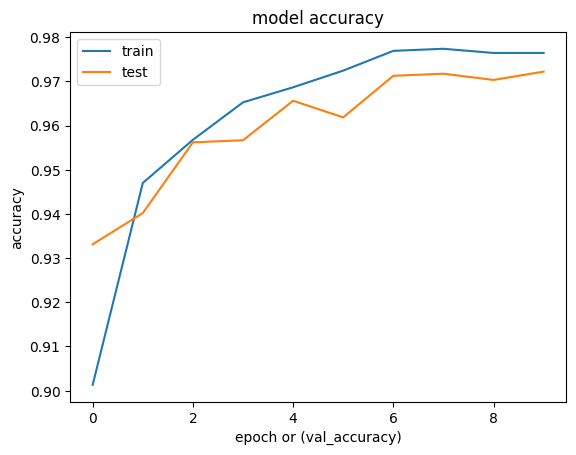

In [12]:
import matplotlib.pyplot as plt
#summarize model for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch or (val_accuracy)')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

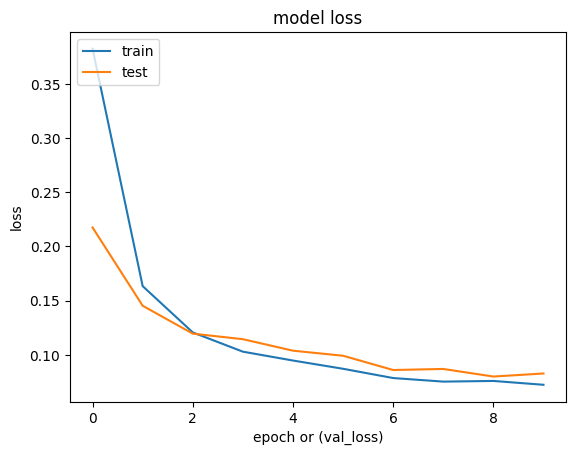

In [13]:
#summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch or (val_loss)')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

67/67 [==============================] - 7s 23ms/step - loss: 0.0826 - accuracy: 0.9722
Validation Accuracy: 97.22%


In [ ]:
# Save the model to a file
model.save("/content/drive/MyDrive/PP-1/Models/UMAFall model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("/content/drive/MyDrive/PP-1/Models/UMAFall model.h5")

# Prepare a single data sample (replace with your actual sensor data)
input_data1 = X_val[0]  # Replace with your sensor data in the right shape
input_data2 = X_val[1]  # Replace with your sensor data in the right shape

# Perform inference using the loaded model
prediction1 = loaded_model.predict(np.expand_dims(input_data1, axis=0))
prediction2 = loaded_model.predict(np.expand_dims(input_data2, axis=0))
# The prediction is a value between 0 and 1
if prediction1[0][0] >= 0.5:
    print("Fall detected")
else:
    print("No fall detected")
if prediction2[0][0] >= 0.5:
    print("Fall detected")
else:
    print("No fall detected")
print(prediction1[0][0])
print(prediction2[0][0])

1/1 [==============================] - 0s 34ms/step
Fall detected
No fall detected
0.92266953
0.0028519956
